In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df = pd.read_csv("/kaggle/input/customer-personality-analysis/marketing_campaign.csv", sep="\t")
df.head()

# About The Dataset

#  PEOPLE

1. ID: Customer's unique identifier.
1. Year_Birth: Customer's birth year.
1. Education: Customer's education level.
1. Marital_Status: Customer's marital status.
1. Income: Customer's yearly household income.
1. Kidhome: Number of children in customer's household.
1. Teenhome: Number of teenagers in customer's household.
1. Dt_Customer: Date of customer's enrollment with the company.
1. Recency: Number of days since customer's last purchase.
1. Complain: 1 if customer complained in the last 2 years, 0 otherwise.**

# PRODUCTS

1. MntWines: Amount spent on wine in last 2 years.
1. MntFruits: Amount spent on fruits in last 2 years.
1. MntMeatProducts: Amount spent on meat in last 2 years.
1. MntFishProducts: Amount spent on fish in last 2 years.
1. MntSweetProducts: Amount spent on sweets in last 2 years.
1. MntGoldProds: Amount spent on gold in last 2 years.

# PROMOTIONS

1. NumDealsPurchases: Number of purchases made with a discount.
1. AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise.
1. AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise.
1. AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise.
1. AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise.
1. AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise.
1. Response: 1 if customer accepted the offer in the last campaign, 0 otherwise.

In [ ]:
df.info()

In [ ]:
df.isnull().sum()[df.isnull().sum()>0]

Income    24

dtype: int64

In [ ]:
df=df.dropna()
print("rows X　columns :",df.shape)

rows X　columns : (2216, 29)


In [ ]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"] ,format ='mixed')
dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)  

print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-12-06

The oldest customer's enrolment date in the records: 2012-01-08

In [ ]:
print("Education:\n",df["Education"].value_counts(),"\n")
print("Marital_Status:\n",df["Marital_Status"].value_counts(),"\n")

In [ ]:
#create age
df['Age']=2023-df['Year_Birth']

#create total spent
df['Spent'] = df['MntWines']+ df['MntFruits'] +df['MntMeatProducts']+ df['MntFishProducts']
+df['MntSweetProducts'] +df['MntGoldProds']

#create children
df['Children'] = df['Kidhome'] +df['Teenhome']

#Parents if children >0
df['Parents'] = df['Children'].apply(lambda x: x>0)


df['Marital_Status'] = df['Marital_Status'].replace({'Widow':'Single',
                                                     'YOLO':'Single',
                                                     'Alone':'Single',
                                                    'Absurd':'Single'})
#create Education
df['Education']=df['Education'].replace({'Basic':'Undergraduate',
                                         '2n Cycle':'Undergraduate'})

In [ ]:
df['Marital_Status'].unique()

In [ ]:
df.describe()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cols=['Age' ,'Income','Spent',"Recency",'Parents']
plt.figure()
sns.pairplot(data =df[cols], hue='Parents')

plt.show()

In [ ]:
#drop  the outliers
df = df[(df["Age"]<100)]
df = df[(df["Income"]<600000)]

print("data :",len(df))
cols=['Age' ,'Income','Spent',"Recency",'Parents']
plt.figure()
sns.pairplot(data =df[cols], hue='Parents')

plt.show()

In [ ]:
to_drop = [ "Z_CostContact", "Z_Revenue", "Year_Birth"]
df = df.drop(to_drop, axis=1)

In [ ]:
df.info()

In [ ]:
#bool -> object
df['Parents'] = df['Parents'].astype('object')
cat_col=['Education','Parents','Marital_Status']
df_cat = pd.get_dummies(df[cat_col])
df_cat = df_cat.astype(int)


In [ ]:
columns = ['Education','Marital_Status','ID','Dt_Customer']
df_2 = df.drop(columns , axis=1)
df_new = pd.concat([df_2,df_cat] ,axis=1)
df_new.info()

In [ ]:
df_new.head()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
scaler = StandardScaler()
scaler.fit(df_new)
scaled_df = pd.DataFrame(scaler.transform(df_new),columns= df_new.columns )

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=13)
pca_df=pca.fit_transform(scaled_df)

list_rat = pca.explained_variance_ratio_
print("explained_variance_:",pca.explained_variance_) 
print("-----------")
print("Total_explained_variance_ratio: %f" %(list_rat.sum()))

pca_df = pd.DataFrame(pca.transform(scaled_df), columns=(["col_1","col_2", "col_3","col_4","col_5",
                                                          "col_6","col_7","col_8","col_9","col_10",
                                                         "col_11","col_12","col_13"]))

explained_variance_: [9.4540396  3.26563684 1.99859219 1.73639726 1.53356817 1.45032217
 1.35923811 1.22581311 1.19427681 1.15841045 1.08332933 1.0153248
 1.00503628]
-----------
Total_explained_variance_ratio: 0.762988

In [ ]:
pca_df.describe().T

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [ ]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=(1,15),random_state=1)
Elbow_M.fit(pca_df)
Elbow_M.show()

In [ ]:
KM = KMeans(n_clusters=3, init = 'k-means++',n_init='auto', random_state=1)
labels = KM.fit_predict(pca_df)
df['labels'] = labels
pca_df['labels'] =labels

In [ ]:
sns.countplot(data=df ,x=df['labels'])
plt.title("Numner of labels")

In [ ]:
pal = ["blue","red", "green"]
sns.scatterplot(data = df,x=df["Spent"], y=df["Income"],hue=df["labels"],palette=pal)
plt.title('Clusters Profile Based On Income And Spending')
plt.show()

In [ ]:
sns.boxplot(data=df, x=df['labels'] , y=df['Spent'],palette=pal)

In [ ]:
df["Total_Promos"] = df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]

sns.countplot(data=df , x=df["Total_Promos"] , hue=df["labels"] ,palette=pal)
plt.title("Count Of Promotion Accepted")

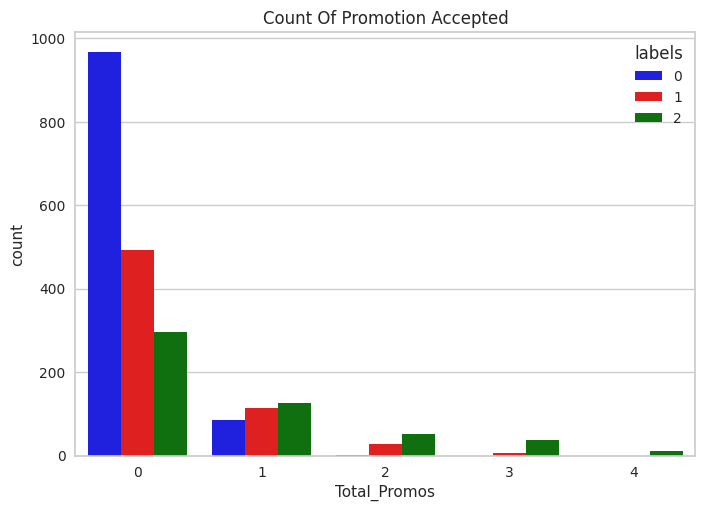

In [ ]:
sns.boxplot(data=df, x=df['labels'] , y=df['NumDealsPurchases'],palette=pal)
plt.title("Number of Deals Purchased")
plt.show()

In [ ]:
df['Marital_Status']=df['Marital_Status'].replace({'Single':1, 
                                                    'Together':2, 
                                                    'Married':3, 
                                                    'Divorced':4, 
                                                  })
#create Education
df['Education']=df['Education'].replace({'Graduation':1,
                                         'PhD':2, 
                                         'Master':3, 
                                         'Undergraduate':4})
df['Parents'] = df['Parents'].astype(int)

In [ ]:
df['Marital_Status'].unique()

In [ ]:
col=["Age", "Children",'Education','Marital_Status','Kidhome','Teenhome']
for i in col:
    plt.figure()
    sns.jointplot(x=df[i], y=df['Spent'], hue=df["labels"],kind="kde", shade=False,palette=pal)
    plt.show()



* group_0 = 年齡層最廣，收入較低，大多有小孩，與其他兩群體相比低學歷
* group_1 = 年齡大多介在40_70，大學學歷以上，大多已婚有小孩(青少年居多)，目標客群2
* group_2 = 已婚無小孩 單身 有另一半，高收入高支出，大學學歷以上，目標客群1